In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib widget

In [2]:
import pandas as pd
from scipy.stats import norm
from scipy import signal

import seaborn as sns
from math import floor

import numpy as np
import matplotlib.pyplot as plt

import copy



from poly2.utils import get_dist_mean, edge_values
from poly2.run import simulations_run, no_joblib_simulations_run
from poly2.config import Config

In [3]:
cs = Config(
    type='single',
    sprays=[2],
    host_on=[False],
    n_k=100,
    verbose=False,
)

In [4]:
doses1 = 1 * np.ones(15)

In [6]:
r1 = no_joblib_simulations_run(
    cs,
    doses=doses1,
)

running simulation


In [7]:
r2 = no_joblib_simulations_run(
    cs,
    doses=doses1,
)

running simulation


In [8]:
r1['spray_2_host_N']['dis_sev'] - r2['spray_2_host_N']['dis_sev']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Plot

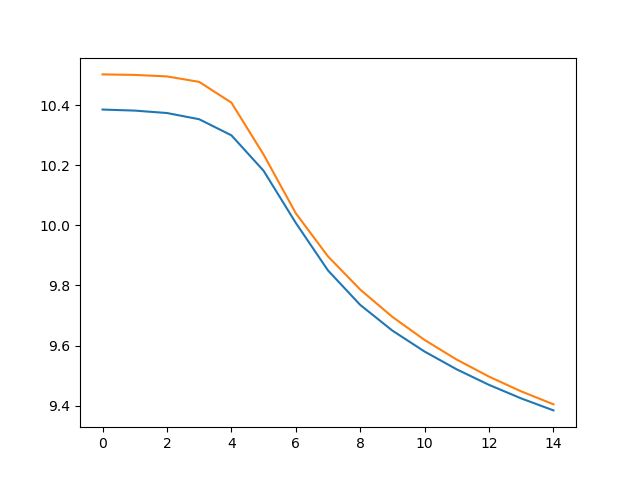

In [8]:
f, ax = plt.subplots()

ax.plot(r1['spray_Y2_host_N']['yield_vec'])
ax.plot(r2['spray_Y2_host_N']['yield_vec'])

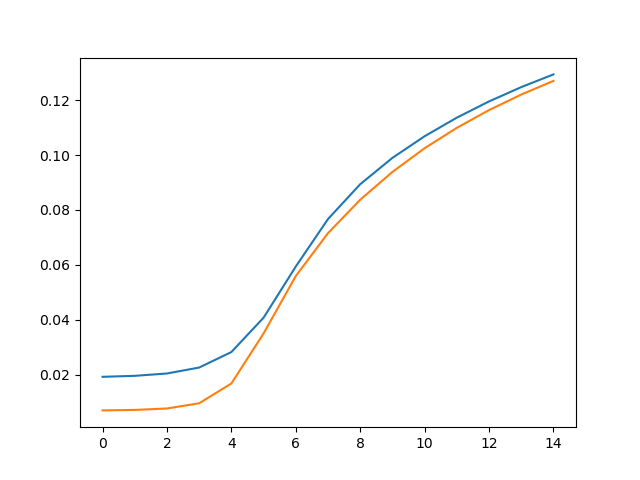

In [9]:
f, ax = plt.subplots()

ax.plot(r1['spray_Y2_host_N']['dis_sev'])
ax.plot(r2['spray_Y2_host_N']['dis_sev'])

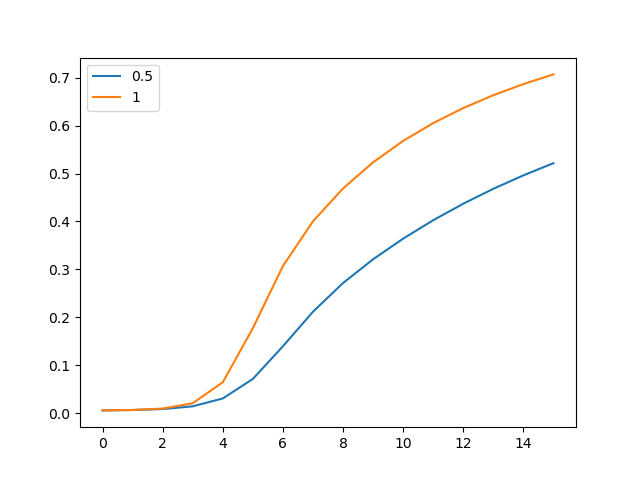

In [10]:
f, ax = plt.subplots()

d1 = get_dist_mean(r1['spray_Y2_host_N']['fung_dists'], r1['spray_Y2_host_N']['k_vec'])
d2 = get_dist_mean(r2['spray_Y2_host_N']['fung_dists'], r2['spray_Y2_host_N']['k_vec'])

ax.plot(d1, label='0.5')
ax.plot(d2, label='1')

ax.legend()

# Simple dose test

In [11]:
cs.sprays = [3]

In [12]:
runs = []

for xx in np.linspace(0, 1, 11):
    doses = xx * np.ones(15)
    rr = no_joblib_simulations_run(
        cs,
        doses_run=doses,
    )
    
    runs.append(rr)

running simulation
changed to transpose!!!
changed to transpose!!!


100%|██████████| 14/14 [00:01<00:00,  7.96it/s]


running simulation
changed to transpose!!!
changed to transpose!!!


100%|██████████| 14/14 [00:02<00:00,  6.75it/s]


running simulation
changed to transpose!!!
changed to transpose!!!


100%|██████████| 14/14 [00:02<00:00,  6.49it/s]


running simulation
changed to transpose!!!
changed to transpose!!!


100%|██████████| 14/14 [00:02<00:00,  6.38it/s]


running simulation
changed to transpose!!!
changed to transpose!!!


100%|██████████| 14/14 [00:02<00:00,  6.40it/s]


running simulation
changed to transpose!!!
changed to transpose!!!


100%|██████████| 14/14 [00:02<00:00,  6.31it/s]


running simulation
changed to transpose!!!
changed to transpose!!!


100%|██████████| 14/14 [00:02<00:00,  6.35it/s]


running simulation
changed to transpose!!!
changed to transpose!!!


100%|██████████| 14/14 [00:02<00:00,  6.39it/s]


running simulation
changed to transpose!!!
changed to transpose!!!


100%|██████████| 14/14 [00:02<00:00,  6.35it/s]


running simulation
changed to transpose!!!
changed to transpose!!!


100%|██████████| 14/14 [00:02<00:00,  6.36it/s]


running simulation
changed to transpose!!!
changed to transpose!!!


100%|██████████| 14/14 [00:02<00:00,  6.39it/s]


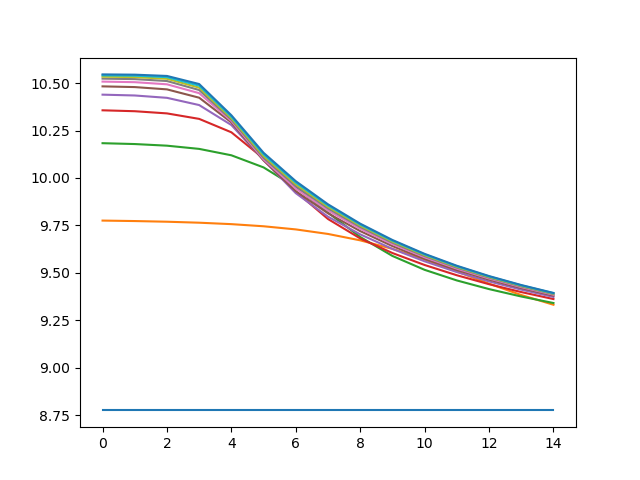

In [13]:
f, ax = plt.subplots()

for rr in runs:
    ax.plot(rr['spray_Y3_host_N']['yield_vec'])

Maybe would be worth checking how things operate if mutation prop was higher?

## Higher mutation prop

In [143]:
cs_m2 = copy.deepcopy(cs)

In [144]:
cs_m2.mutation_proportion = 2e-2

In [16]:
runs = []

for xx in np.linspace(0, 1, 11):
    doses = xx * np.ones(15)
    
    rr = no_joblib_simulations_run(
        cs_m2,
        doses_run=doses,
        verbose=False
    )
    
    runs.append(rr)

changed to transpose!!!
changed to transpose!!!


100%|██████████| 14/14 [00:01<00:00,  7.95it/s]


changed to transpose!!!
changed to transpose!!!


100%|██████████| 14/14 [00:02<00:00,  6.73it/s]


changed to transpose!!!
changed to transpose!!!


100%|██████████| 14/14 [00:02<00:00,  6.46it/s]


changed to transpose!!!
changed to transpose!!!


100%|██████████| 14/14 [00:02<00:00,  6.44it/s]


changed to transpose!!!
changed to transpose!!!


100%|██████████| 14/14 [00:02<00:00,  6.45it/s]


changed to transpose!!!
changed to transpose!!!


100%|██████████| 14/14 [00:02<00:00,  6.40it/s]


changed to transpose!!!
changed to transpose!!!


100%|██████████| 14/14 [00:02<00:00,  6.36it/s]


changed to transpose!!!
changed to transpose!!!


100%|██████████| 14/14 [00:02<00:00,  6.28it/s]


changed to transpose!!!
changed to transpose!!!


100%|██████████| 14/14 [00:02<00:00,  6.27it/s]


changed to transpose!!!
changed to transpose!!!


100%|██████████| 14/14 [00:02<00:00,  6.41it/s]


changed to transpose!!!
changed to transpose!!!


100%|██████████| 14/14 [00:02<00:00,  6.39it/s]


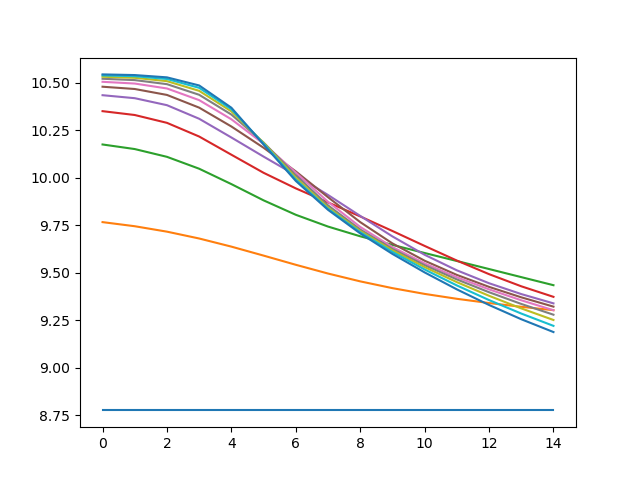

In [17]:
f, ax = plt.subplots()

for rr in runs:
    ax.plot(rr['spray_Y3_host_N']['yield_vec'])

## Compare with sprays = 0!

In [7]:
def dispersal(vec, parent_index, mut_scale):

    stan_dev = mut_scale**0.5

    edges = edge_values(len(vec))

    disp = norm.cdf(edges, loc=vec[parent_index], scale=stan_dev)

    dispersing = np.diff(disp)

    top = 1 - disp[-1]

    bottom = disp[0]

    dispersing[0] += bottom

    dispersing[-1] += top

    return dispersing

In [8]:
def get_kernel(vec, p, mutation_scale):
    N = len(vec)

    kernel = np.zeros((N, N))

    for parent in range(N):
        # some proportion stays at position i
        not_dispersing = signal.unit_impulse(N, parent)

        dispersing = dispersal(vec, parent, mutation_scale)

        kernel[parent, :] = p*dispersing + (1-p)*not_dispersing

    return kernel

In [32]:
cs3 = copy.deepcopy(cs_m2)

cs3.sprays = [0]

In [33]:
rr = no_joblib_simulations_run(
    cs3,
    doses_run=doses,
    verbose=False
)

changed to transpose!!!
changed to transpose!!!


100%|██████████| 14/14 [00:00<00:00, 16.30it/s]


In [34]:
kk = rr['spray_N_host_N']['k_vec']

In [35]:
mm = get_kernel(kk, 0.1, 0.1)

In [36]:
yy = rr['spray_N_host_N']['y'][:, :, 0]

In [37]:
old_I = yy[:-1, 0]

In [38]:
new_I = np.matmul(mm.T, yy[:-1, 0])

In [42]:
sum(old_I) - sum(new_I)

-5.421010862427522e-20

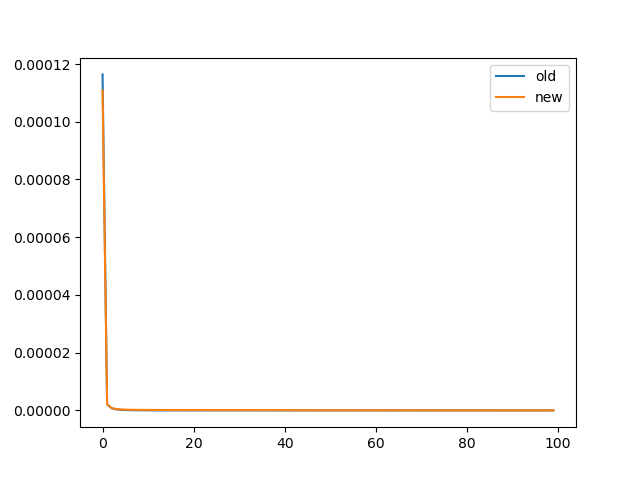

In [43]:
f, ax = plt.subplots()

ax.plot(old_I, label='old')
ax.plot(new_I, label='new')

ax.legend()

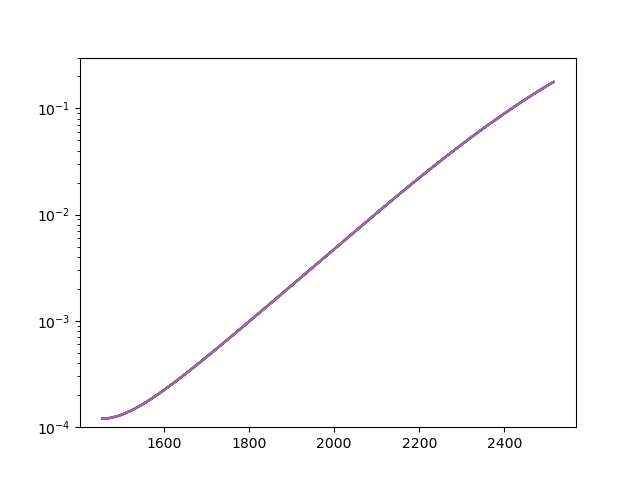

In [44]:
f, ax = plt.subplots()

for ii in range(15):
    ax.plot(rr['spray_N_host_N']['t'], rr['spray_N_host_N']['total_I'][:, ii])
    
ax.set_ylim([1e-4, 3e-1])

ax.set_yscale('log')

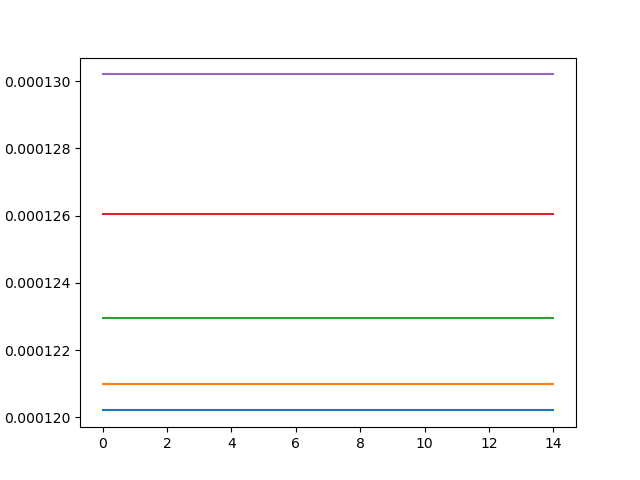

In [45]:
f, ax = plt.subplots()

for ii in range(5):
    ax.plot(rr['spray_N_host_N']['total_I'][ii, :])

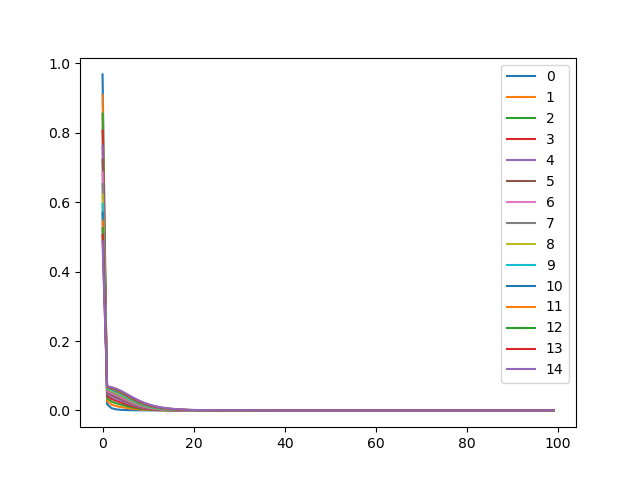

In [46]:
f,ax = plt.subplots()

for ii in range(15):
    ax.plot(rr['spray_N_host_N']['fung_dists'][:, ii], label=ii)
    
ax.legend()

# Now check the mutation array thing

In [211]:
csboth = Config(
    type='single',
    sprays=[1],
    host_on=[True],
    n_k=50,
    n_l=50,
    n_years=3,
    verbose=False,
)

In [254]:
csboth.mutation_proportion = 1e-2 # 1e-2
csboth.mutation_scale_fung = 1e-1 # 0.1
csboth.mutation_scale_host = 1e-6

In [255]:
rb = no_joblib_simulations_run(
    csboth,
    doses_run=np.zeros(5)
)

running simulation
changed to transpose!!!
changed to transpose!!!
starting things
changed order of h1, h2
finishing things


100%|██████████| 2/2 [00:06<00:00,  3.08s/it]


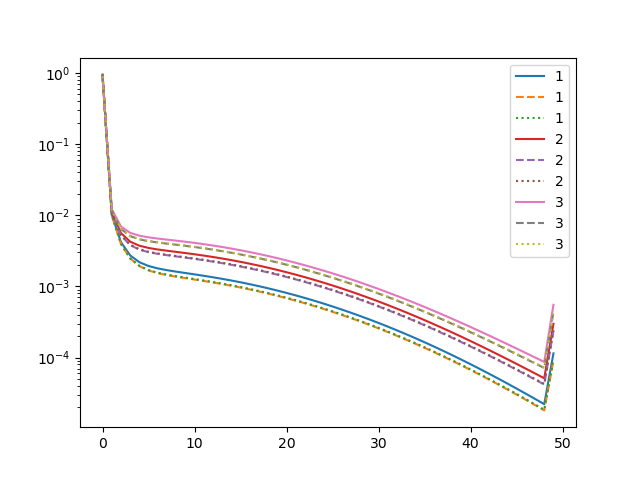

In [425]:
f, ax = plt.subplots()

for ii in range(1, 4):
    ax.plot(ro['spray_Y1_host_N']['fung_dists'][:, ii], label=ii)
    ax.plot(rbt['fung_dists'][:, ii], label=ii, ls='--')
    ax.plot(rb['spray_Y1_host_Y']['fung_dists'][:, ii], label=ii, ls=':')
    
ax.legend()

ax.set_yscale('log')

# ax.set_ylim([1e-5, 1e-2])

## Compare to new sim object

In [310]:
from poly2.simulator import SimulatorBothTraits

In [312]:
(1/0.2) * np.outer(
    [0.1, 0, 0.1],
    [0.1, 0.1]
)

array([[0.05, 0.05],
       [0.  , 0.  ],
       [0.05, 0.05]])

In [ ]:
rbt = SimulatorBothTraits(csboth, number_of_sprays=1).run_model(
    I0_vec=[csboth.I0_single]*3,
    beta_vec=[csboth.beta_single]*3,
    doses=[0]*3
)

## and compare fung to without host

In [327]:
csone = Config(
    type='single',
    sprays=[1],
    host_on=[False],
    n_k=50,
    n_l=50,
    n_years=3,
    verbose=False,
)

In [328]:
csone.mutation_proportion = 1e-2
csone.mutation_scale_fung = 1e-1
csone.mutation_scale_host = 1e-6

In [329]:
ro = no_joblib_simulations_run(
    csone,
    doses_run=np.zeros(5)
)

running simulation
changed to transpose!!!
changed to transpose!!!


100%|██████████| 2/2 [00:00<00:00, 18.93it/s]


# Now check host situ

In [324]:
csoneh = Config(
    type='single',
    sprays=[0],
    host_on=[True],
    n_k=50,
    n_l=50,
    n_years=3,
    verbose=False,
)

In [325]:
csoneh.mutation_proportion = 1e-2
csoneh.mutation_scale_fung = 1e-1
csoneh.mutation_scale_host = 1e-1

In [326]:
roh = no_joblib_simulations_run(
    csoneh
)

running simulation
changed to transpose!!!
changed to transpose!!!


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


In [330]:
csbothh = Config(
    type='single',
    sprays=[0],
    host_on=[False],
    n_k=50,
    n_l=50,
    n_years=3,
    verbose=False,
)

In [331]:
csbothh.mutation_proportion = 1e-2
csbothh.mutation_scale_fung = 1e-1
csbothh.mutation_scale_host = 1e-1

In [423]:
rbth = SimulatorBothTraits(
    csbothh,
    number_of_sprays=0
).run_model(
    I0_vec=[csboth.I0_single]*3,
    beta_vec=[csboth.beta_single]*3,
    doses=[0]*3
)

changed to transpose!!!
changed to transpose!!!


100%|██████████| 2/2 [00:00<00:00,  3.03it/s]


It seems to work if `host_effect` is all 1 for fungicide, or similarly for host.

So something to do with recombining the arrays and it systematically shifting things.

Something to do with the way we use `np.outer`?

# Testing

The system should give same `fung_dists` regardless of the host situation

In [411]:
host_effect = 0.1*np.array([1/6, 1/2, 5/6])
# host_effect = 0.1*np.ones(3)

In [412]:
I_F = np.array([0.1, 0.3, 0.6])
I_H = np.array([0.1, 0.7, 0.2])

In [413]:
res = (
    np.outer(
        I_F,
        host_effect*I_H
    ) * (1/I_H.sum())
)

res

array([[0.00016667, 0.0035    , 0.00166667],
       [0.0005    , 0.0105    , 0.005     ],
       [0.001     , 0.021     , 0.01      ]])

In [414]:
# FUNG
res.sum(axis=1) / res.sum().sum()

array([0.1, 0.3, 0.6])

In [415]:
# HOST
res.sum(axis=0) / res.sum().sum()

array([0.03125, 0.65625, 0.3125 ])

Host effect should be redundant, so that the increase in fung dist throughout the season due to mutation is the same whether host is on or off.

No it shouldn't! Because more new generations means that more mutation occurs.

(0.01, 0.02)

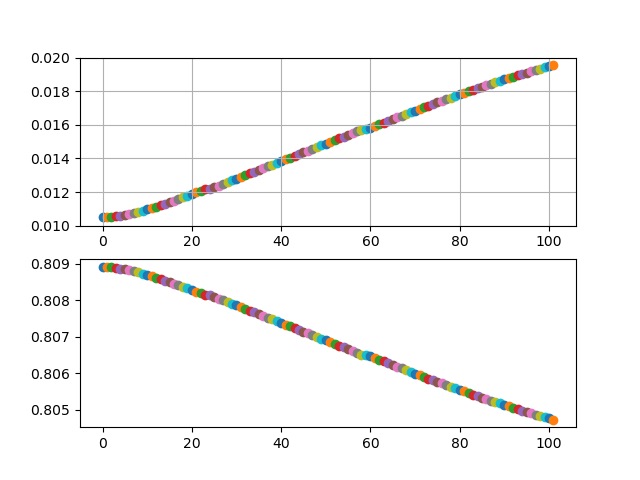

In [424]:
f, ax = plt.subplots(2, 1)


for ii in range(102):
    yy = np.reshape(
        rbth['y'][:-1, ii, 0],
        (50,50)
    )
    
    dmf = np.dot(
        yy.sum(axis=1) / yy.sum().sum(), 
        rbth['k_vec']
    )
    
    dmh = np.dot(
        yy.sum(axis=0) / yy.sum().sum(),
        rbth['l_vec']
    )
    
    ax[0].scatter(ii, dmf)
    ax[1].scatter(ii, dmh)

ax[0].grid()

ax[0].set_ylim([1e-2, 2e-2])

(0.01, 0.02)

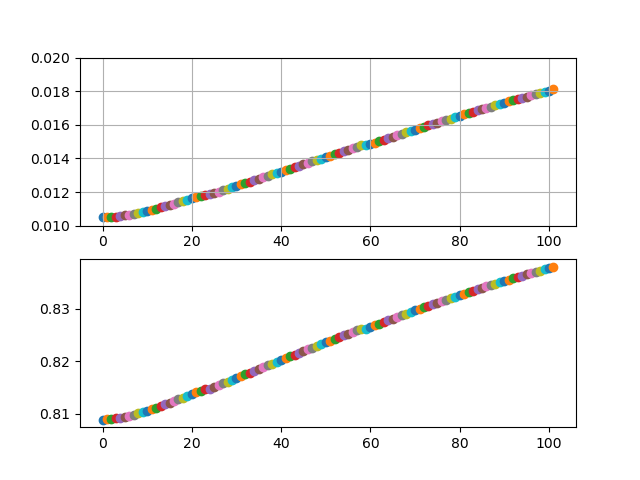

In [405]:
f, ax = plt.subplots(2, 1)


for ii in range(102):
    yy = np.reshape(
        rbt['y'][:-1, ii, 0],
        (50,50)
    )
    
    dmf = np.dot(
        yy.sum(axis=1) / yy.sum().sum(), 
        rbt['k_vec']
    )
    
    dmh = np.dot(
        yy.sum(axis=0) / yy.sum().sum(),
        rbt['l_vec']
    )
    
    ax[0].scatter(ii, dmf)
    ax[1].scatter(ii, dmh)

ax[0].grid()
ax[0].set_ylim([1e-2, 2e-2])

(0.01, 0.02)

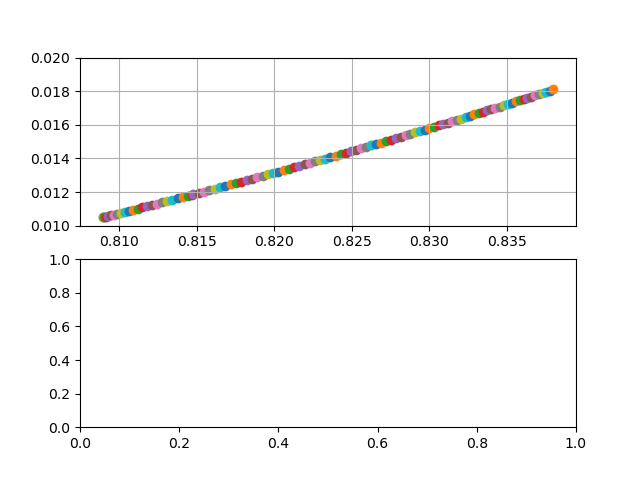

In [416]:
f, ax = plt.subplots(2, 1)


for ii in range(102):
    yy = np.reshape(
        rbt['y'][:-1, ii, 0],
        (50,50)
    )
    
    dmf = np.dot(
        yy.sum(axis=1) / yy.sum().sum(), 
        rbt['k_vec']
    )
    
    dmh = np.dot(
        yy.sum(axis=0) / yy.sum().sum(),
        rbt['l_vec']
    )
    
    ax[0].scatter(dmh, dmf)
    # ax[1].scatter(ii, dmh)

ax[0].grid()
ax[0].set_ylim([1e-2, 2e-2])

Why should mutation be higher if the host is turned off??

# Summary of changes

OK so off the top of my head the changes are:

- Remove the mutation reduce boxes thing... `l_start` and `k_start` etc

- Change kernels to transpose of kernels: `[parent, :]` becomes `[:, parent]`

- Mutation array calculated once in run model (i think) not in solve_it

- Might have to change the way that mutation array is calculated in the host and fung case

- Separate `SimulatorBothTraits` and remove `k_mu`, `k_b` etc from `SimulatorBothTraits`

- Can use `array.sum(axis=1)` instead of ugly list comprehensions

- Removed `get_mutation_array` and some other methods